# Analysis

This notebook analyses the final set of papers found by the snowballing and coding selection process. 

The list of papers analysied is the spreadsheet CodedPapers.xlsx, containing the results of coding all the rounds.


In [1]:
# !pip install google-search-results
from serpapi import GoogleScholarSearch
from ScholarUtils import GetPapers, GetPaper, WellCitedPapers, InitScholar, RelatedQuery, RelatedRef, NumCitations

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import pickle
import seaborn as sns
import os
import statsmodels.stats.inter_rater as ir
import networkx as nx

# Change to an appropriate location:
imageDir='/Users/charles/Dropbox/Doc/4 Lancaster/PapersAndPresentations/DCSSurveyPaper/generated' 

# Some image defaults:
sns.set_palette("colorblind")
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = 8,4

# Reload ScholarUtils every time before executing code 
%load_ext autoreload
%autoreload 2

def Savefig(identifier):
    # Save the current image as an image file identified by the string identifier
    plt.savefig( os.path.join(imageDir, identifier + '.pdf'), bbox_inches='tight' ) 

In [3]:
InitScholar("APIKey.yaml")

In [4]:
# Get all the coded papers, and filter out those we've accepted:
allPreviousPapersDf=pd.read_excel('CodedPapers.xlsx', 
                                # Want Key as string, not number, to match WellCitedPapers() output:
                              dtype={'Key':np.str_}) 
acceptedPapersDf=allPreviousPapersDf.query('AgreedScore>6').copy()
print(len(acceptedPapersDf))
acceptedPapersDf

79


,Unnamed: 0,Key,Round,Citations,Year,Title,Authors,Link,Related,Snippet,AgreedScore,NeedsDiscuss,Pierre,P Comment,Charles,C comment,Agreement,Unnamed: 16
0,0,17567618191233461182,1,643,2000,Software engineering for security: a roadmap,"PT Devanbu, S Stubblebine",https://dl.acm.org/doi/abs/10.1145/336512.336559,visp7qq3zPMJ,Is there such a thing anymore as a software sy...,7.0,NaN,7.0,7,6.0,Agreed 7 with Pierre,7.0,NaN
1,1,7379463099867128855,1,183,2016,You get where you're looking for: The impact o...,"Y Acar, M Backes, S Fahl, D Kim…",https://ieeexplore.ieee.org/abstract/document/...,F-SuXJceaWYJ,Vulnerabilities in Android code--including but...,8.0,NaN,8.0,8,8.0,NaN,NaN,NaN
2,2,3515120953808077324,1,18,2019,A Survey on Developer-Centred Security,"M Tahaei, K Vaniea",https://ieeexplore.ieee.org/abstract/document/...,DEJDMuI3yDAJ,Software developers are key players in the sec...,9.0,NaN,9.0,9,9.0,NaN,NaN,NaN
53,53,782252406809913637,2,298,2004,The trustworthy computing security development...,S Lipner,https://ieeexplore.ieee.org/abstract/document/...,JWmZYGse2woJ,This paper discusses the trustworthy computing...,7.0,NaN,7.0,7 (3 2 2),5.0,NaN,7.0,P: Not really about developer behaviour
54,54,16155454764124359910,2,150,2017,Comparing the usability of cryptographic apis,"Y Acar, M Backes, S Fahl, S Garfinkel…",https://ieeexplore.ieee.org/abstract/document/...,5kyGQIO0M-AJ,Potentially dangerous cryptography errors are ...,9.0,NaN,9.0,9,9.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,483,6269436597767213116,3,25,2017,Privacystreams: Enabling transparency in perso...,"Y Li, F Chen, TJJ Li, Y Guo, G Huang…",https://dl.acm.org/doi/abs/10.1145/3130941,PJC_Z16DAVcJ,Smartphone app developers often access and use...,7.0,0.0,6.0,6 (3 2 1),7.0,"Yes, they call 'developers' 'users' in the abs...",7.0,NaN
514,514,662201613823385404,4,133,2018,Do developers update their library dependencies?,"RG Kula, DM German, A Ouni, T Ishio…",https://link.springer.com/article/10.1007/s106...,PB-i-ducMAkJ,Third-party library reuse has become common pr...,8.0,1.0,8.0,8 (3 2 3),8.0,NaN,NaN,NaN
558,558,8515816864495030621,4,92,2018,Lessons from building static analysis tools at...,"C Sadowski, E Aftandilian, A Eagle…",https://pub-tools-public-publication-data.stor...,XdGBzFFCLnYJ,SOFTWARE BUGS COST developers and software com...,8.0,1.0,8.0,8 (3 3 2),6.0,Is this almost a duplicate?,NaN,NaN
604,604,3189859254953420294,4,65,2017,DevSecOps: a multivocal literature review,"H Myrbakken, R Colomo-Palacios",https://www.researchgate.net/profile/Havard-My...,Bqb9fheoRCwJ,Involving security in DevOps has been a challe...,7.0,1.0,5.0,5 (2 1 2),8.0,NaN,NaN,NaN


In [5]:
# Calculate the Inter-rater reliability (Cohen Kappa)

for rnd in range(2,acceptedPapersDf.Round.max()+1):
    papersDf=(acceptedPapersDf.query('Round=={}'.format(rnd))
              [['Pierre','Charles']]
              .fillna(0)
              .applymap(lambda x: int(x) > 6 ) # We're only interested in accept or not.
             )
    matrix,bins= ir.to_table(papersDf)
    proportionAgreed=(matrix[0][0] + matrix[1][1]) / matrix.sum().sum()
    print( "Round {}: {:.0%} agreement\n{}\n{}".format(rnd,proportionAgreed,ir.cohens_kappa(matrix),matrix) )

Round 2: 69% agreement
                  Simple Kappa Coefficient
              --------------------------------
              Kappa                     -0.0532
              ASE                       0.0501
              95% Lower Conf Limit      -0.1514
              95% Upper Conf Limit      0.0450

                 Test of H0: Simple Kappa = 0

              ASE under H0              0.0846
              Z                         -0.6290
              One-sided Pr >  Z         0.7353
              Two-sided Pr > |Z|        0.5294

[[ 0. 10.]
 [ 1. 25.]]
Round 3: 83% agreement
                  Simple Kappa Coefficient
              --------------------------------
              Kappa                     -0.0800
              ASE                       0.0407
              95% Lower Conf Limit      -0.1598
              95% Upper Conf Limit      -0.0002

                 Test of H0: Simple Kappa = 0

              ASE under H0              0.1555
              Z                      

26

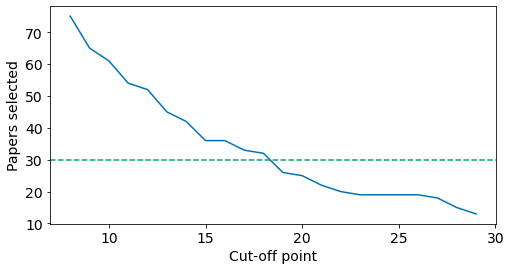

In [6]:
# After Round 3, we plot the number of accepted papers we get for different citation cut-offs.

def CitationsNeeded(year, **kwargs):
    req=kwargs['req']
    return req / 2 if year >= 2020 else (2020 - year) * req

round3Df=acceptedPapersDf.query('Round<=3')
pd.Series({ req: (round3Df.Citations >= round3Df.Year.apply(CitationsNeeded, req=req)).sum()
 for req in range(8, 30)}).plot()
plt.xlabel("Cut-off point")
plt.ylabel("Papers selected")
plt.axhline(y=30, color='C2', linestyle='--')
Savefig('CitationLimits')

# How many citations as a result of chosing 19?
(round3Df.Citations >= round3Df.Year.apply(CitationsNeeded, req=19)).sum()

In [7]:
#So, choose 19:
chosenPapersDf=(acceptedPapersDf.assign( citationsRequired=acceptedPapersDf.Year.apply(CitationsNeeded, req=19) )
                .query('Citations >= citationsRequired'))
print(len(chosenPapersDf))

30


# Clustering

Use the 'related articles' list as a closeness measure for clustering the papers:

In [8]:
# Now we want, for each paper, in a column, the related papers as a map, key the Related ID, 
#   value the position of that related paper in the list.

# This takes a long time.
def RelatedPaperMap(relatedId):
    allRelatedPapers= GetPapers(RelatedQuery(relatedId))
    return {RelatedRef(p) : idx for idx, p in enumerate(allRelatedPapers)}

papersWithRelatedPapersListDf=(chosenPapersDf
                              .assign(Associations=[RelatedPaperMap(paper.Related) 
                                                   for paper in chosenPapersDf.itertuples()])
                              )

Retrieving 101 papers for {'q': 'related:visp7qq3zPMJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:F-SuXJceaWYJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:5kyGQIO0M-AJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:REeYepPp3SkJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:d7UnA3YnVJkJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:P0WfqhZ2obYJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:OrGABxMmhcEJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:JuK69hzgtjcJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:k9MSObR3_DsJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:jFuiYUk7tXIJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:MIMMzPye1kcJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:-QbkIgBuQeoJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:i8bJLDJpvRoJ:scholar.google.com/'}
Retrieving 1

In [ ]:
#The Google queries take a long time and can cost money. 
#To make this repeatable we 'comment out' the slow parts by changing the cell type to 'Raw NB Convert'; 
# to redo the queries, convert them back again to Code.

with open( "papersWithRelatedPapers.p", "wb" ) as outFile:
    pickle.dump( papersWithRelatedPapersListDf, outFile )

In [9]:
# Create a unique short name for each paper:
def CiteDescription(paper):
    # E.g. Acar+2016
    authorSurnames=re.split(r'[ ,]*[A-Z]* ', paper.Authors)[1:]
    authorCite=(authorSurnames[0] if len(authorSurnames)==1 
            else '&'.join(authorSurnames) if len(authorSurnames)==2
            else authorSurnames[0] + '+')
    return '{}{:d}'.format(authorCite, paper.Year)

#Add 'a','b' etc to the end to differentiate repeated descriptions ('Acar+2016a')
baseDescriptions=[CiteDescription(p) for p in papersWithRelatedPapersListDf.itertuples()]

# Kludge: Google Scholar doesn't have space for third author in Bednar, Spiekermann et al. 
papersWithRelatedAndCitesDf=(papersWithRelatedPapersListDf
            .assign(Cite=[ 'Bednar+2019' if 'Bednar' in name else
                name + ['','a','b','c'][len([earlierName for earlierName in baseDescriptions[0:idx] if earlierName==name])]
     for idx, name in enumerate(baseDescriptions)]))

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, set_link_color_palette
from scipy.spatial.distance import pdist
# Perform Agglomerative clustering

# pdist is the distance metric between two papers: 
# pdist's distance function receives two arrays containing the elements of two rows 
# of the dataframe. The array index of the items we want is the column index in the dataframe:
theAssociationsLoc=papersWithRelatedAndCitesDf.columns.get_loc("Associations") # e.g. 11
theIdLoc=papersWithRelatedAndCitesDf.columns.get_loc("Related")
NOT_ASSOCIATED=101 # Distance for items not in the 'associated papers' list of either papers considered.

def Distance(paper1, paper2):
    return min(paper1[theAssociationsLoc].get(paper2[theIdLoc], NOT_ASSOCIATED),
               paper2[theAssociationsLoc].get(paper1[theIdLoc], NOT_ASSOCIATED))

# The linkage method choses how each two clusters are compared for distance:
#       single, complete, weighted, average, ward
#‘ward’ minimizes the variance of the clusters being merged.
#‘average’ uses the average of the distances of each observation of the two sets.
#‘complete’ or ‘maximum’ linkage uses the maximum distances between all observations of the two sets.
#‘single’ uses the minimum of the distances between all observations of the two sets.

Z = linkage(pdist(papersWithRelatedAndCitesDf, Distance), 'ward', optimal_ordering=False)

In [11]:
# Bit more magic, to get the cluster numbers (1,2,3...) for each paper:
clusterCutoff=NOT_ASSOCIATED-1 # Tweek to get an acceptable number of clusters.
clusteredPapersDf=(papersWithRelatedAndCitesDf.
                             assign(Cluster = fcluster(Z, t=clusterCutoff, criterion='distance') # t chosen to correspond to the x-axis separate point above.
                                   )
                            )
# Most of the clusters aren't interesting. Create 'groups' from the ones with more than 2 elements:
clusterSizes=clusteredPapersDf['Cluster'].value_counts()
groupMap=(clusterSizes[clusterSizes>2].to_frame()
            .assign(Group=lambda df: range(1,len(df)+1))
            ['Group']
                   )

def Group(cluster):
    return groupMap.get(cluster,0)
    
NumGroups=groupMap.max()
NumGroups

3

In [12]:
def NodeColour(n):
    # Answer a colour for this node. 
    # There's a colour for the unclustered nodes:
    if Z[n-len(clusteredPapersDf)][2] > clusterCutoff: 
        return 'C0'
    # otherwise follow the tree to a paper and see what group that is in.
    while n >= len(clusteredPapersDf):
        n=int(Z[n-len(clusteredPapersDf)][0])
    return 'C{}'.format(Group(clusteredPapersDf.iloc[n].Cluster))

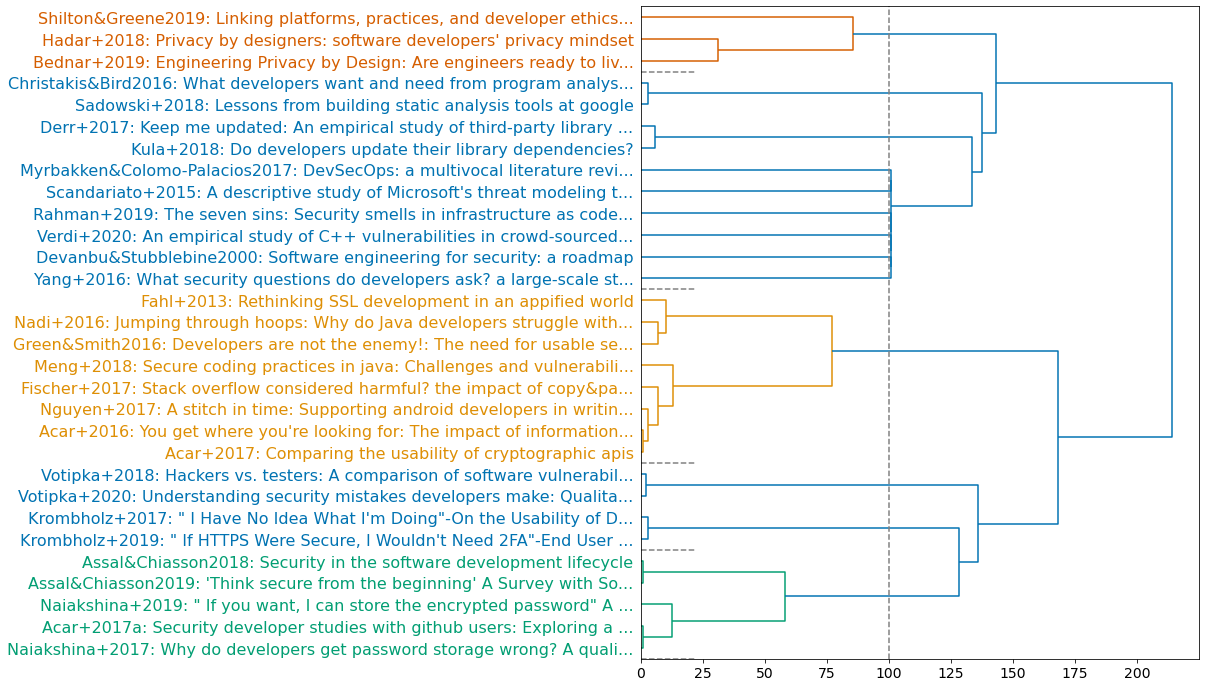

In [13]:
plt.figure(figsize=(10, 12))
longLabels=['{}: {}'.format(p.Cite, p.Title) for p in clusteredPapersDf.itertuples()]
MAX_TITLE_LENGTH=70
truncatedLabels=[label[:MAX_TITLE_LENGTH] + ('...' if len(label) > MAX_TITLE_LENGTH else '')
                 for label in longLabels
                ]
                            
dn = dendrogram(Z, 
                orientation='right', 
                leaf_font_size=16, 
                #count_sort='descending', # Tweek sorting to give good arrangement. 
                link_color_func=NodeColour,
                distance_sort='descending'
               )

# Kludge the labels to the group color used in the cluster diagram, and add a separator between groups

yTicks, yTickLabels = plt.yticks()
currentGroup=0
for i in yTickLabels:
    itemNumber=int(i.get_text())
    thisItemsGroup=Group(clusteredPapersDf.iloc[itemNumber].Cluster)
    if thisItemsGroup != currentGroup:
        if True: # currentGroup != 0:
            # Draw a line here:
            plt.axhline(y=i.get_position()[1] - 5, color='grey', xmax=0.1, linestyle='--')
        currentGroup = thisItemsGroup
    i.set_color( 'C{}'.format(thisItemsGroup)) 
    i.set_text(truncatedLabels[itemNumber])
plt.yticks(yTicks, labels=yTickLabels)

plt.axvline(x=clusterCutoff, color='grey', linestyle='--')

Savefig('clusters')

# Citation map

We use the 'cited by' functionality to track citation links between the papers:

In [17]:
def CitingPapers(paperSeries):
    # Use WellCitedPapers, because we're only interested in links between those papers:
    allCitingPapers= WellCitedPapers(GetPapers({'cites': paperSeries.Key}))
    return [paper.Key for paper in allCitingPapers.itertuples()]

# This takes a long time...
papersWithClustersAndCitedByDf=(clusteredPapersDf
                                .assign(CitedBy=[CitingPapers(paper) 
                                                 for paper in clusteredPapersDf.itertuples()]
                                       ))

Retrieving 645 papers for {'cites': '17567618191233461182'}
Retrieving 188 papers for {'cites': '7379463099867128855'}
Retrieving 158 papers for {'cites': '16155454764124359910'}
Retrieving 158 papers for {'cites': '3016824145034364740'}
Retrieving 70 papers for {'cites': '11048499173659227511'}
Retrieving 155 papers for {'cites': '13159929425877222719'}
Retrieving 128 papers for {'cites': '13944593684394717498'}
Retrieving 67 papers for {'cites': '4014642532850524710'}
Retrieving 67 papers for {'cites': '4322461358304187283'}
Retrieving 187 papers for {'cites': '8265577877465095052'}
Retrieving 67 papers for {'cites': '5176499630301283120'}
Retrieving 61 papers for {'cites': '16879893825225754361'}
Retrieving 63 papers for {'cites': '1926811879805142667'}
Retrieving 45 papers for {'cites': '16377826307460433036'}
Retrieving 62 papers for {'cites': '14628707085616601823'}
Retrieving 21 papers for {'cites': '4325511156220754863'}
Retrieving 34 papers for {'cites': '15383107825067827060'

In [18]:
with open( "papersWithCitedBy.p", "wb" ) as outFile:
    pickle.dump( papersWithClustersAndCitedByDf, outFile )

In [19]:
with open( "papersWithCitedBy.p", "rb" ) as inFile:
    papersWithClustersAndCitedByDf=pickle.load( inFile )
len(papersWithClustersAndCitedByDf)

30

In [20]:
workingDf=(papersWithClustersAndCitedByDf.copy()
           .set_index(['Key'], drop=False)
          )

edges=[(cFrom, paper.Key) for paper in workingDf.itertuples() 
         for cFrom in paper.CitedBy if cFrom in workingDf.Key.values 
     ]

G = nx.DiGraph()
G.add_edges_from(edges)

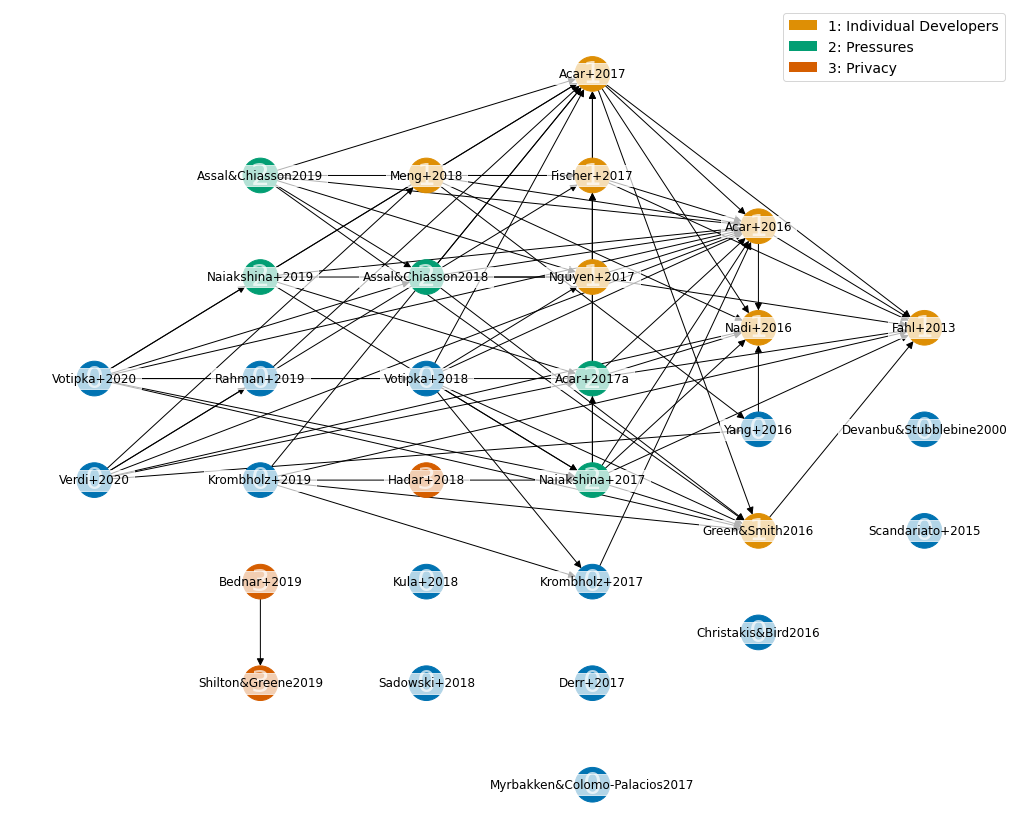

In [21]:
# Use a columns layout, where each column is a year, with the latest years on the left:
def Subset(paper):
    return 2022-paper.Year if paper.Year > 2015 else 2022-2015
G.add_nodes_from([(paper.Key, {'subset': Subset(paper)}) for paper in workingDf.itertuples()])
positions=nx.multipartite_layout(G)

# Move the items for some years up slightly so the texts don't overlap:
#delta=0.05
#positions={k: (np.array([pos[0],pos[1]+delta]) if workingDf.loc[k].Year in (2020,2018,2016) else pos) 
#           for k, pos in positions.items()}

# And move Hadar+2018 out of the way so it doesn't look as though it has lots of links:
#hadar=positions['9873211921093443394']
#positions['9873211921093443394']=(hadar[0],hadar[1]-0.75)

fig=plt.figure(figsize =(18, 15))

# We want two lots of node labels, one with the group numbers large, in white, and underneath the correct ones.
# So draw the group labels in the main network drawing process, and add the paper titles afterwards:

nx.draw_networkx(G,
                 # Need to specify explicitly the nodes, even though they're in G, to ensure ordering:
                 nodelist=[paper.Key for paper in workingDf.itertuples()],
                 node_color=['C{}'.format(Group(paper.Cluster)) for paper in workingDf.itertuples()], 
                 pos=positions, 
                 labels={paper.Key: Group(paper.Cluster) for paper in workingDf.itertuples()},
                 font_size=30,
                 font_color=(1,1,1,0.7),
                 node_size=1200,
                 arrowsize=15
                )

nx.draw_networkx_labels(G,
                 pos=positions, 
                 labels={paper.Key: paper.Cite for paper in workingDf.itertuples()},
                 bbox=dict(facecolor=(1,1,1,0.7), edgecolor=(1,1,1,0.7)),
                )    

groupNames={2: 'Pressures', 1: 'Individual Developers', 3: 'Privacy'}
plt.legend(handles=[matplotlib.patches.Patch(facecolor='C{}'.format(i), label='{}: {}'.format(i, groupNames[i])) 
                    for i in range(1,NumGroups+1)])

## Magic to remove bounding box:
for spine in plt.gca().spines.values():
    spine.set_visible(False)
Savefig('citationLinks')

# List of authors and venues

Google Scholar isn't good at author lists and venues. Save as a spreadsheet and fix them manually.

In [22]:
papersWithClustersAndCitedByDf[['Key','Cite','Round','Citations','Year','Title', 'Authors','Link']].to_excel('SelectedPapers.xlsx')

In [23]:
!open SelectedPapers.xlsx
assert(False) # And STOP!

AssertionError: 

In [ ]:
!open SelectedPapersSaved.xlsx

... then add Venue and Authors columns to SelectedPapers.xlsx and save it as SelectedPapersSaved.xlsx
This has to be done manually, as Scholar truncates the author list and isn't very clear on venues.

In [ ]:
venuesDf=pd.read_excel('SelectedPapersSaved.xlsx')
len(venuesDf)

In [ ]:
# List of venues:
venuesDf.Venue.value_counts()

In [ ]:
# Table of all authors with more than one paper. 
# Save to a spreadsheet as the easiest way to create a table.
(venuesDf
    .assign(Author=venuesDf.Authors.str.split(','))
    .explode('Author')
    .assign(Author=lambda df: df.Author.str.strip())
    [['Author']] 
    .value_counts()
    .to_frame('Count')
    .query('Count>1')
    .to_excel('Authors.xlsx')
)
!open authors.xlsx

In [ ]:
assert(False)

In [ ]:
!open ScholarUtils.py

In [ ]:
!open SelectedPapers.xlsx